In [1]:
import open3d as o3d
import numpy as np
import copy
import os
import sys
import time

if o3d.__DEVICE_API__ == 'cuda':
    import open3d.cuda.pybind.t.pipelines.registration as treg
else:
    import open3d.cpu.pybind.t.pipelines.registration as treg

# monkey patches visualization and provides helpers to load geometries
sys.path.append('..')
import open3d_tutorial as o3dtut
# change to True if you want to interact with the visualization windows
o3dtut.interactive = not "CI" in os.environ

[download_utils.py] /home/rey/workspace/isl/clean/Open3D/examples/test_data/open3d_downloads/RGBD/raycast_vtx_004.npy already exists, skipped.
[download_utils.py] /home/rey/workspace/isl/clean/Open3D/examples/test_data/open3d_downloads/RGBD/normal_map.npy already exists, skipped.
[download_utils.py] /home/rey/workspace/isl/clean/Open3D/examples/test_data/open3d_downloads/tests/bunnyData.pts already exists, skipped.
[download_utils.py] /home/rey/workspace/isl/clean/Open3D/examples/test_data/open3d_downloads/tests/point_cloud_sample1.pts already exists, skipped.
[download_utils.py] /home/rey/workspace/isl/clean/Open3D/examples/test_data/open3d_downloads/tests/point_cloud_sample2.pts already exists, skipped.
[download_utils.py] /home/rey/workspace/isl/clean/Open3D/examples/test_data/open3d_downloads/tests/cube.obj already exists, skipped.
[download_utils.py] /home/rey/workspace/isl/clean/Open3D/examples/test_data/open3d_downloads/RGBD/vertex_map.npy already exists, skipped.


## Helper visualization function
The function below visualizes a target point cloud and a source point cloud transformed with an alignment transformation. The target point cloud and the source point cloud are painted with cyan and yellow colors respectively. The more and tighter the two point-clouds overlap with each other, the better the alignment result.

In [2]:
def draw_registration_result(source, target, transformation):
    source_temp = source.clone()
    target_temp = target.clone()

    source_temp.transform(transformation)
    # o3d.visualization.draw([source_temp, target_temp])

    o3d.visualization.draw_geometries(
        [source_temp.to_legacy(),
         target_temp.to_legacy()],
        zoom=0.4459,
        front=[0.9288, -0.2951, -0.2242],
        lookat=[1.6784, 2.0612, 1.4451],
        up=[-0.3402, -0.9189, -0.1996])

# ICP registration
This tutorial demonstrates the ICP (Iterative Closest Point) registration algorithm. It has been a mainstay of geometric registration in both research and industry for many years. The inputs are two point clouds and an initial transformation that roughly aligns the source point cloud to the target point cloud. The output is a refined transformation that tightly aligns the two point clouds. A helper function `draw_registration_result` visualizes the alignment during the registration process. In this tutorial, we show differnt ICP variants, and the API for using them.

## Understanding ICP Algorithm

In general, the ICP algorithm iterates over two steps:

1. Find correspondence set $\mathcal{K}=\{(\mathbf{p}, \mathbf{q})\}$ from target point cloud $\mathbf{P}$, and source point cloud $\mathbf{Q}$ transformed with current transformation matrix $\mathbf{T}$.
2. Update the transformation $\mathbf{T}$ by minimizing an objective function $E(\mathbf{T})$ defined over the correspondence set $\mathcal{K}$.

Different variants of ICP use different objective functions $E(\mathbf{T})$ [\[BeslAndMcKay1992\]](../reference.html#beslandmckay1992) [\[ChenAndMedioni1992\]](../reference.html#chenandmedioni1992) [\[Park2017\]](../reference.html#park2017).

## Different variants of ICP

## Point-to-point ICP

We first show a point-to-point ICP algorithm [\[BeslAndMcKay1992\]](../reference.html#beslandmckay1992) using the objective

\begin{equation}
E(\mathbf{T}) = \sum_{(\mathbf{p},\mathbf{q})\in\mathcal{K}}\|\mathbf{p} - \mathbf{T}\mathbf{q}\|^{2}
\end{equation}

The class `TransformationEstimationPointToPoint` provides functions to compute the residuals and Jacobian matrices of the point-to-point ICP objective.

---

## Point-to-plane ICP
The point-to-plane ICP algorithm [\[ChenAndMedioni1992\]](../reference.html#chenandmedioni1992) uses a different objective function

\begin{equation}
E(\mathbf{T}) = \sum_{(\mathbf{p},\mathbf{q})\in\mathcal{K}}\big((\mathbf{p} - \mathbf{T}\mathbf{q})\cdot\mathbf{n}_{\mathbf{p}}\big)^{2},
\end{equation}

where $\mathbf{n}_{\mathbf{p}}$ is the normal of point $\mathbf{p}$. [\[Rusinkiewicz2001\]](../reference.html#rusinkiewicz2001) has shown that the point-to-plane ICP algorithm has a faster convergence speed than the point-to-point ICP algorithm.

The class `TransformationEstimationPointToPlane` provides functions to compute the residuals and Jacobian matrices of the point-to-plane ICP objective. 

---

## Colored ICP

Following [\[Park2017\]](../reference.html#park2017), it runs ICP iterations with a joint optimization objective

\begin{equation}
E(\mathbf{T}) = (1-\delta)E_{C}(\mathbf{T}) + \delta E_{G}(\mathbf{T})
\end{equation}

where $\mathbf{T}$ is the transformation matrix to be estimated. $E_{C}$ and $E_{G}$ are the photometric and geometric terms, respectively. $\delta\in[0,1]$ is a weight parameter that has been determined empirically.

The geometric term $E_{G}$ is the same as the [Point-to-plane ICP](../pipelines/icp_registration.ipynb#Point-to-plane-ICP) objective

\begin{equation}
E_{G}(\mathbf{T}) = \sum_{(\mathbf{p},\mathbf{q})\in\mathcal{K}}\big((\mathbf{p} - \mathbf{T}\mathbf{q})\cdot\mathbf{n}_{\mathbf{p}}\big)^{2},
\end{equation}

where $\mathcal{K}$ is the correspondence set in the current iteration. $\mathbf{n}_{\mathbf{p}}$ is the normal of point $\mathbf{p}$.

The color term $E_{C}$ measures the difference between the color of point $\mathbf{q}$ (denoted as $C(\mathbf{q})$) and the color of its projection on the tangent plane of $\mathbf{p}$.

\begin{equation}
E_{C}(\mathbf{T}) = \sum_{(\mathbf{p},\mathbf{q})\in\mathcal{K}}\big(C_{\mathbf{p}}(\mathbf{f}(\mathbf{T}\mathbf{q})) - C(\mathbf{q})\big)^{2},
\end{equation}

where $C_{\mathbf{p}}(\cdot)$ is a precomputed function continuously defined on the tangent plane of $\mathbf{p}$. Function$\mathbf{f}(\cdot)$ projects a 3D point to the tangent plane. For more details, refer to [\[Park2017\]](../reference.html#park2017).

To further improve efficiency, [\[Park2017\]](../reference.html#park2017) proposes a multi-scale registration scheme. 

The class `TransformationEstimationForColoredICP` provides functions to compute the residuals and Jacobian matrices of the joint optimization objective. 

---

## Input
The code below reads a source point cloud and a target point cloud from two files. A rough transformation is given.

<div class="alert alert-info">
    
**Note:** 

The initial alignment is usually obtained by a global registration algorithm. See [Global registration](../pipelines/global_registration.rst) for examples.

</div>

### Input: PointClouds between which the `Transformation` is to be estimated. [open3d.t.PointCloud]
- Source Tensor PointCloud. [Float32 or Float64 dtypes are supported].
- Target Tensor PointCloud. [Float32 or Float64 dtypes are supported].

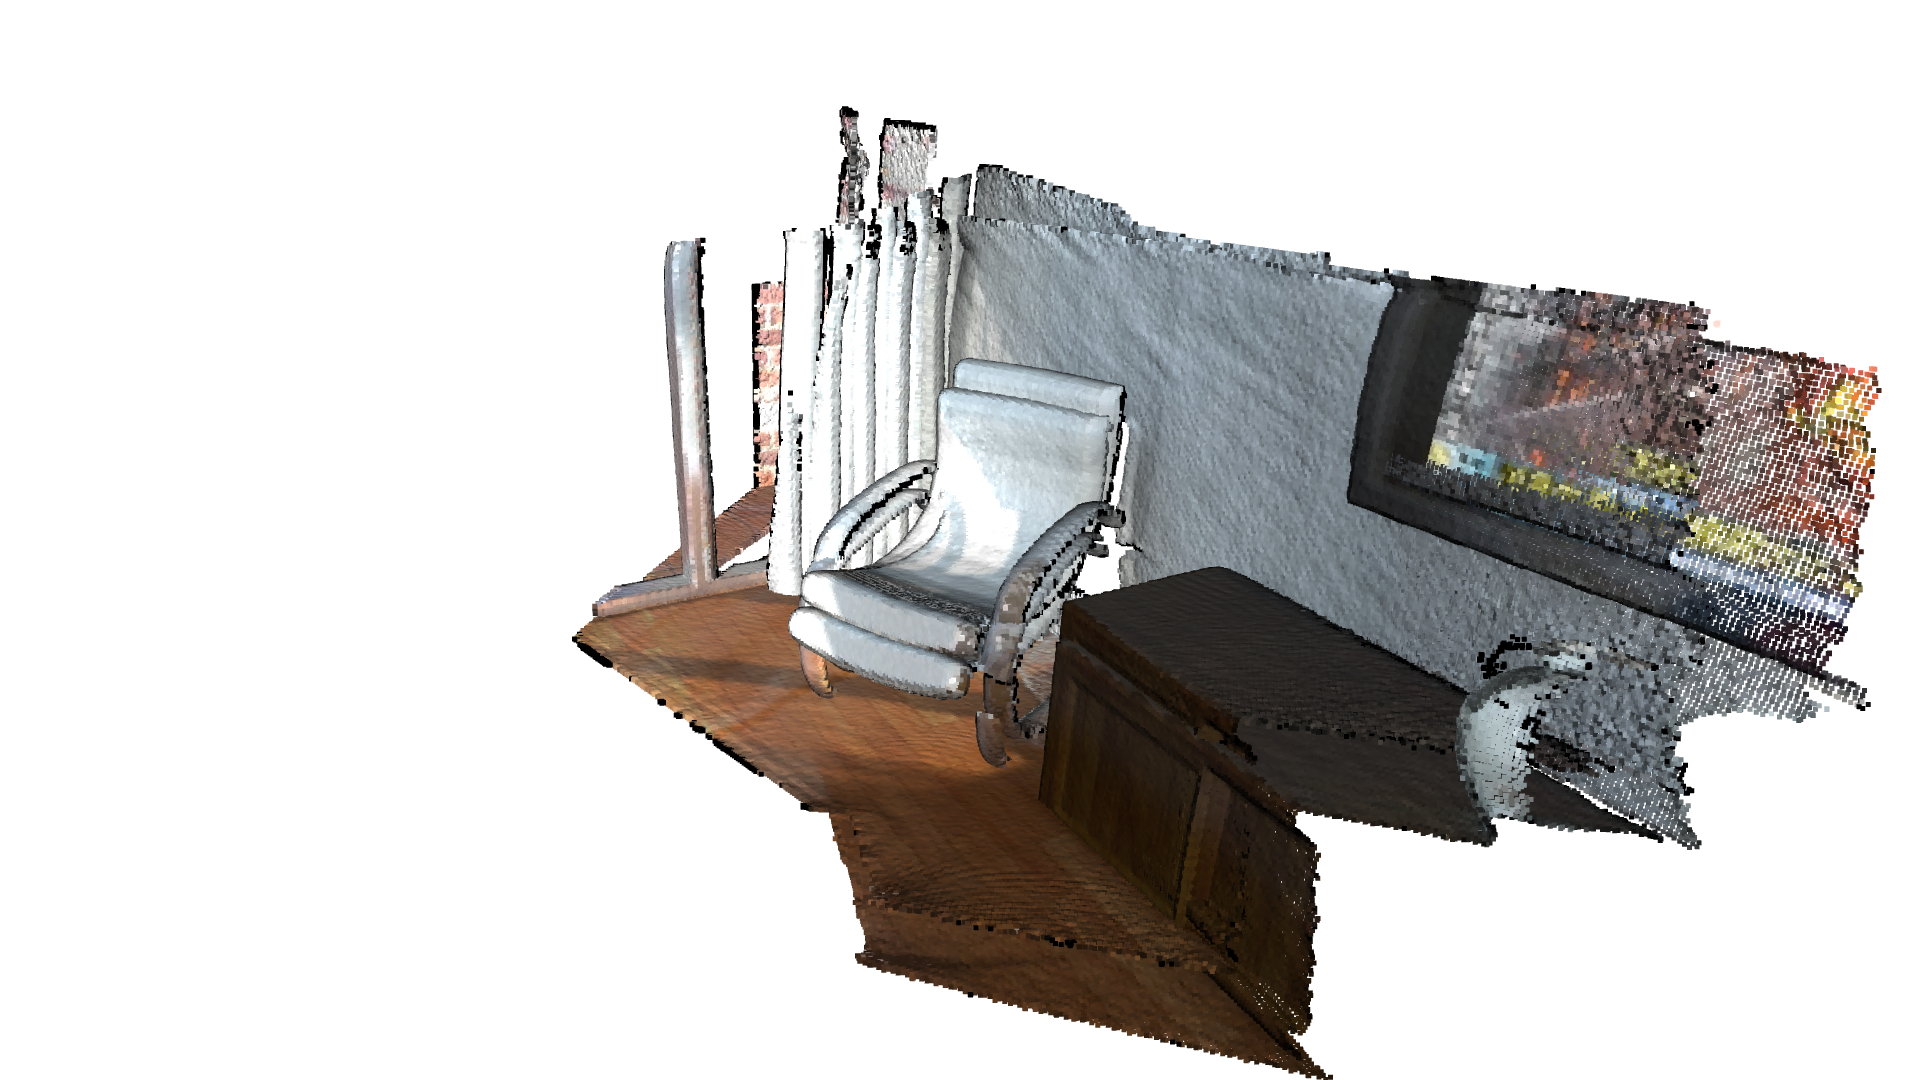

In [3]:
source = o3d.t.io.read_point_cloud("../../test_data/ICP/cloud_bin_0.pcd")
target = o3d.t.io.read_point_cloud("../../test_data/ICP/cloud_bin_1.pcd")

# For Colored-ICP `colors` attribute must be of the same dtype as `positions` and `normals` attribute.
source.point["colors"] = source.point["colors"].to(
    o3d.core.Dtype.Float32) / 255.0
target.point["colors"] = target.point["colors"].to(
    o3d.core.Dtype.Float32) / 255.0

# Initial guess transform between the two point-cloud.
# ICP algortihm requires a good initial allignment to converge efficiently.
trans_init = np.asarray([[0.862, 0.011, -0.507, 0.5],
                         [-0.139, 0.967, -0.215, 0.7],
                         [0.487, 0.255, 0.835, -1.4], [0.0, 0.0, 0.0, 1.0]])

draw_registration_result(source, target, trans_init)

---

## Parameters 

### Max correspondence Distances
- This is the radius of distance from each point in the source point-cloud in which the neighbour search will try to find a corresponding point in the target point-cloud.
- It is a `double` for `ICP`, and `utility.DoubleVector` for `Multi-Scale-ICP`.
- One may typically keep this parameter between 1.0x - 3.0x `voxel-size` for each scale.
- This parameter is most important for performance tuning, as a higher radius will take larger time (as the neighbour search will be performed over a larger radius).

In [4]:
# For Vanilla ICP (double)

# Search distance for Nearest Neighbour Search [Hybrid-Search is used].
max_correspondence_distance = 0.07

In [5]:
# For Multi-Scale ICP (o3d.utility.DoubleVector):

# `max_correspondence_distances` is proportianal to the resolution or the `voxel_sizes`.
# In general we recommend using values between 1x - 3x of the corresponding `voxel_sizes`.
# One may have a higher value of the `max_correspondence_distances` for the first coarse
# scale, as it is not much expensive, and gives us more tolerance to initial allignment.
max_correspondence_distances = o3d.utility.DoubleVector([0.3, 0.14, 0.07])

### Initial Transform from Source to Target [open3d.core.Tensor]
- Initial estimate for transformation from source to target.
- Transformation matrix Tensor of shape [4, 4] of type `Float64` on `CPU:0` device
- The initial alignment is usually obtained by a global registration algorithm. See [Global registration](../pipelines/global_registration.rst) for examples.

In [17]:
# Initial alignment or source to target transform.
init_source_to_target = np.asarray([[0.862, 0.011, -0.507, 0.5],
                                    [-0.139, 0.967, -0.215, 0.7],
                                    [0.487, 0.255, 0.835, -1.4],
                                    [0.0, 0.0, 0.0, 1.0]])
print(o3d.core.Tensor(init_source_to_target))

[[0.862 0.011 -0.507000 0.5],
 [-0.139 0.967 -0.215 0.7],
 [0.487 0.255 0.835 -1.4],
 [0.0 0.0 0.0 1.0]]
Tensor[shape={4, 4}, stride={4, 1}, Float64, CPU:0, 0x56536aad1480]


### Estimation Method 
- This sets the ICP method to compute the transformation between two point-clouds given the correspondences.

Options:

- **o3d.t.pipelines.registration.TransformationEstimationPointToPoint()**
    - Point to Point ICP.
- **o3d.t.pipelines.registration.TransformationEstimationPointToPlane(robust_kernel)**
    - Point to Plane ICP.
    - Requires `target point-cloud` to have `normals` attribute (of same dtype as `position` attribute).
- **o3d.t.pipelines.registration.TransformationEstimationForColoredICP(robust_kernel, lambda)**
    - Colored ICP.
    - Requires `target` point-cloud to have `normals` attribute (of same dtype as `position` attribute).
    - Requires `source` and `target` point-clouds to have `colors` attribute (of same dtype as `position` attribute).
- **o3d.t.pipelines.registration.TransformationEstimationForGeneralizedICP(robust_kernel, epsilon)** [To be added].
    - Generalized ICP.


In [7]:
# Select the `Estimation Method`, and `Robust Kernel` (for outlier-rejection).
estimation = treg.TransformationEstimationPointToPlane()

#### Estimation Method also supports `Robust Kernels`: Robust kernels are used for outlier rejection. More on this in `Robust Kernel` section.

`robust_kernel = o3d.t.pipelines.registration.robust_kernel.RobustKernel(method, scale, shape)`
Method options
- robust_kernel.RobustKernelMethod.L2Loss
- robust_kernel.RobustKernelMethod.L1Loss
- robust_kernel.RobustKernelMethod.HuberLoss
- robust_kernel.RobustKernelMethod.CauchyLoss
- robust_kernel.RobustKernelMethod.GMLoss
- robust_kernel.RobustKernelMethod.TurkeyLoss
- robust_kernel.RobustKernelMethod.GeneralizedLoss


### ICP Convergence Criteria [relative rmse, relative fitness, max iterations]
- This sets the condition for termination or when the scale iterations can be considered to be converged. 
- If the relative (of change in value from the last iteration) rmse and fitness are equal or less than the specified value, the iterations for that scale will be considered as converged/completed.
- For `Multi-Scale ICP` it is a `list` of `ICPConvergenceCriteria`, for each scale of ICP, to provide more fine control over performance.
- One may keep the initial values of `relative_fitness` and `relative_rmse` low as we just want to get an estimate transformation, and high for later iterations to fine-tune.
- Iterations on higher-resolution is more costly (takes more time), so we want to do fewer iterations on higher resolution.

In [8]:
# Convergence-Criteria for Vanilla ICP:

criteria = treg.ICPConvergenceCriteria(relative_fitness=0.000001,
                                       relative_rmse=0.000001,
                                       max_iteration=50)

In [9]:
# List of Convergence-Criteria for Multi-Scale ICP:

# We can control `ConvergenceCriteria` of each `scale` individually.
# We want to keep `relative_fitness` and `relative_rmse` high (more error tolerance)
# for initial scales, i.e. we will be happy to consider ICP converged, when difference
# between 2 successive iterations for that scale is smaller than this value.
# We expect less accuracy (more error tolerance) initial coarse-scale iteration,
# and want our later scale convergence to be more accurate (less error tolerance).
criteria_list = [
    treg.ICPConvergenceCriteria(relative_fitness=0.0001,
                                relative_rmse=0.0001,
                                max_iteration=20),
    treg.ICPConvergenceCriteria(0.00001, 0.00001, 15),
    treg.ICPConvergenceCriteria(0.000001, 0.000001, 10)
]

### Voxel Sizes
- It is the voxel size (lower voxel size corresponds to higher resolution), for each scale of multi-scale ICP.
- We want to perform initial iterations on a coarse point-cloud (low-resolution or small voxel size) (as it is more time-efficient, and avoids local-minima), and then move to a dense point-cloud (high-resolution or small voxel size. Therefore the voxel sizes must be strictly decreasing order.

In [10]:
# Vanilla ICP
voxel_size = 0.025

In [11]:
# Lower `voxel_size` is equivalent to higher resolution,
# and we want to perform iterations from coarse to dense resolution,
# therefore `voxel_sizes` must be in strictly decressing order.
voxel_sizes = o3d.utility.DoubleVector([0.1, 0.05, 0.025])

### Save Information Map
When `True`, it saves the iteration-wise values of `fitness`, `inlier_rmse`, `transformaton`, `scale`, `iteration` in `info_map_` in `regsitration_result`. Default: `False`.

In [12]:
save_info_map = True

---

## ICP Example

Time taken by ICP:  0.12445664405822754
Inlier Fitness:  0.6755917076201774
Inlier RMSE:  0.017589597385283266


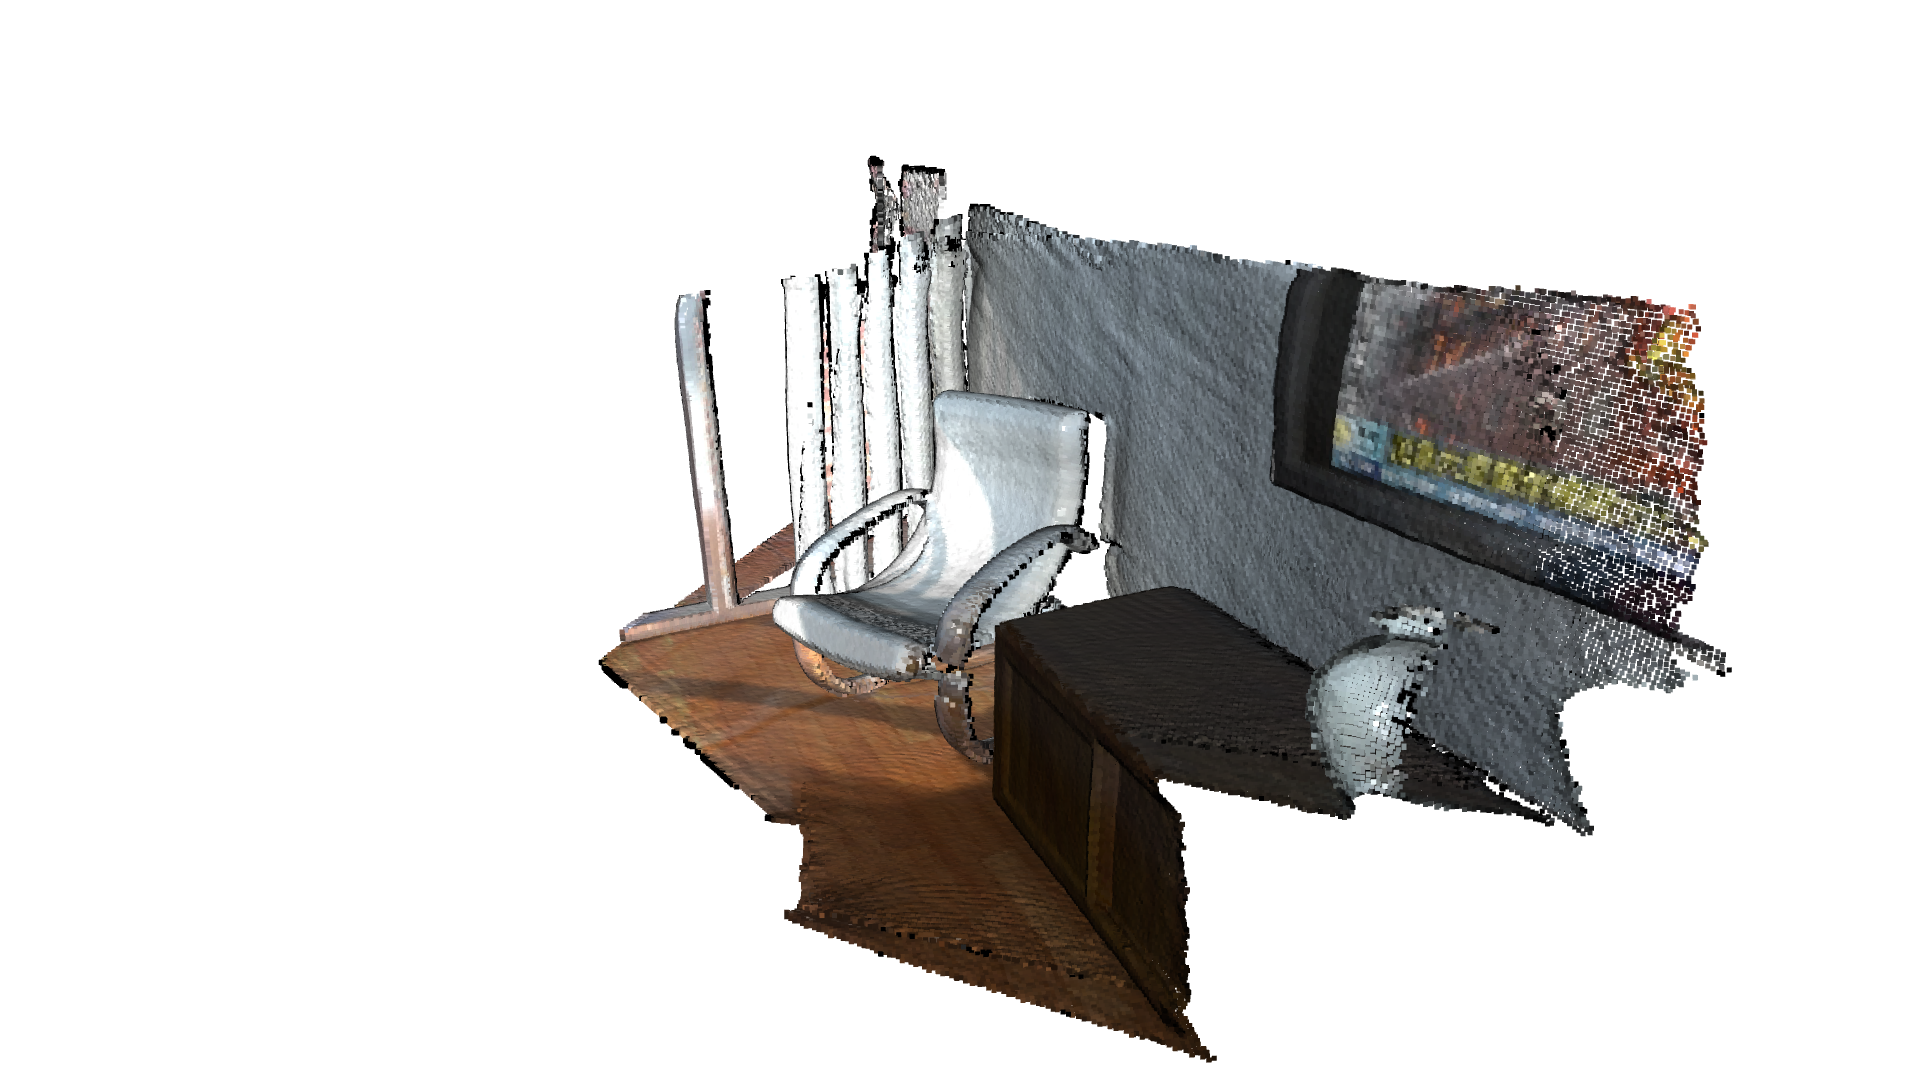

In [13]:
s = time.time()
# It is highly recommended to down-sample the point-cloud before using
# ICP algorithm, for better performance.

registration_result_vanilla_icp = treg.icp(source, target,
                                           max_correspondence_distance,
                                           init_source_to_target, estimation,
                                           criteria, voxel_size, save_info_map)

icp_time = time.time() - s
print("Time taken by ICP: ", icp_time)
print("Inlier Fitness: ", registration_result_vanilla_icp.fitness)
print("Inlier RMSE: ", registration_result_vanilla_icp.inlier_rmse)

draw_registration_result(source, target,
                         registration_result_vanilla_icp.transformation)

---

### Now let's try with poor initial initialisation

Time taken by ICP:  0.1577131748199463
Inlier Fitness:  0.31576568943116984
Inlier RMSE:  0.033497244547741285


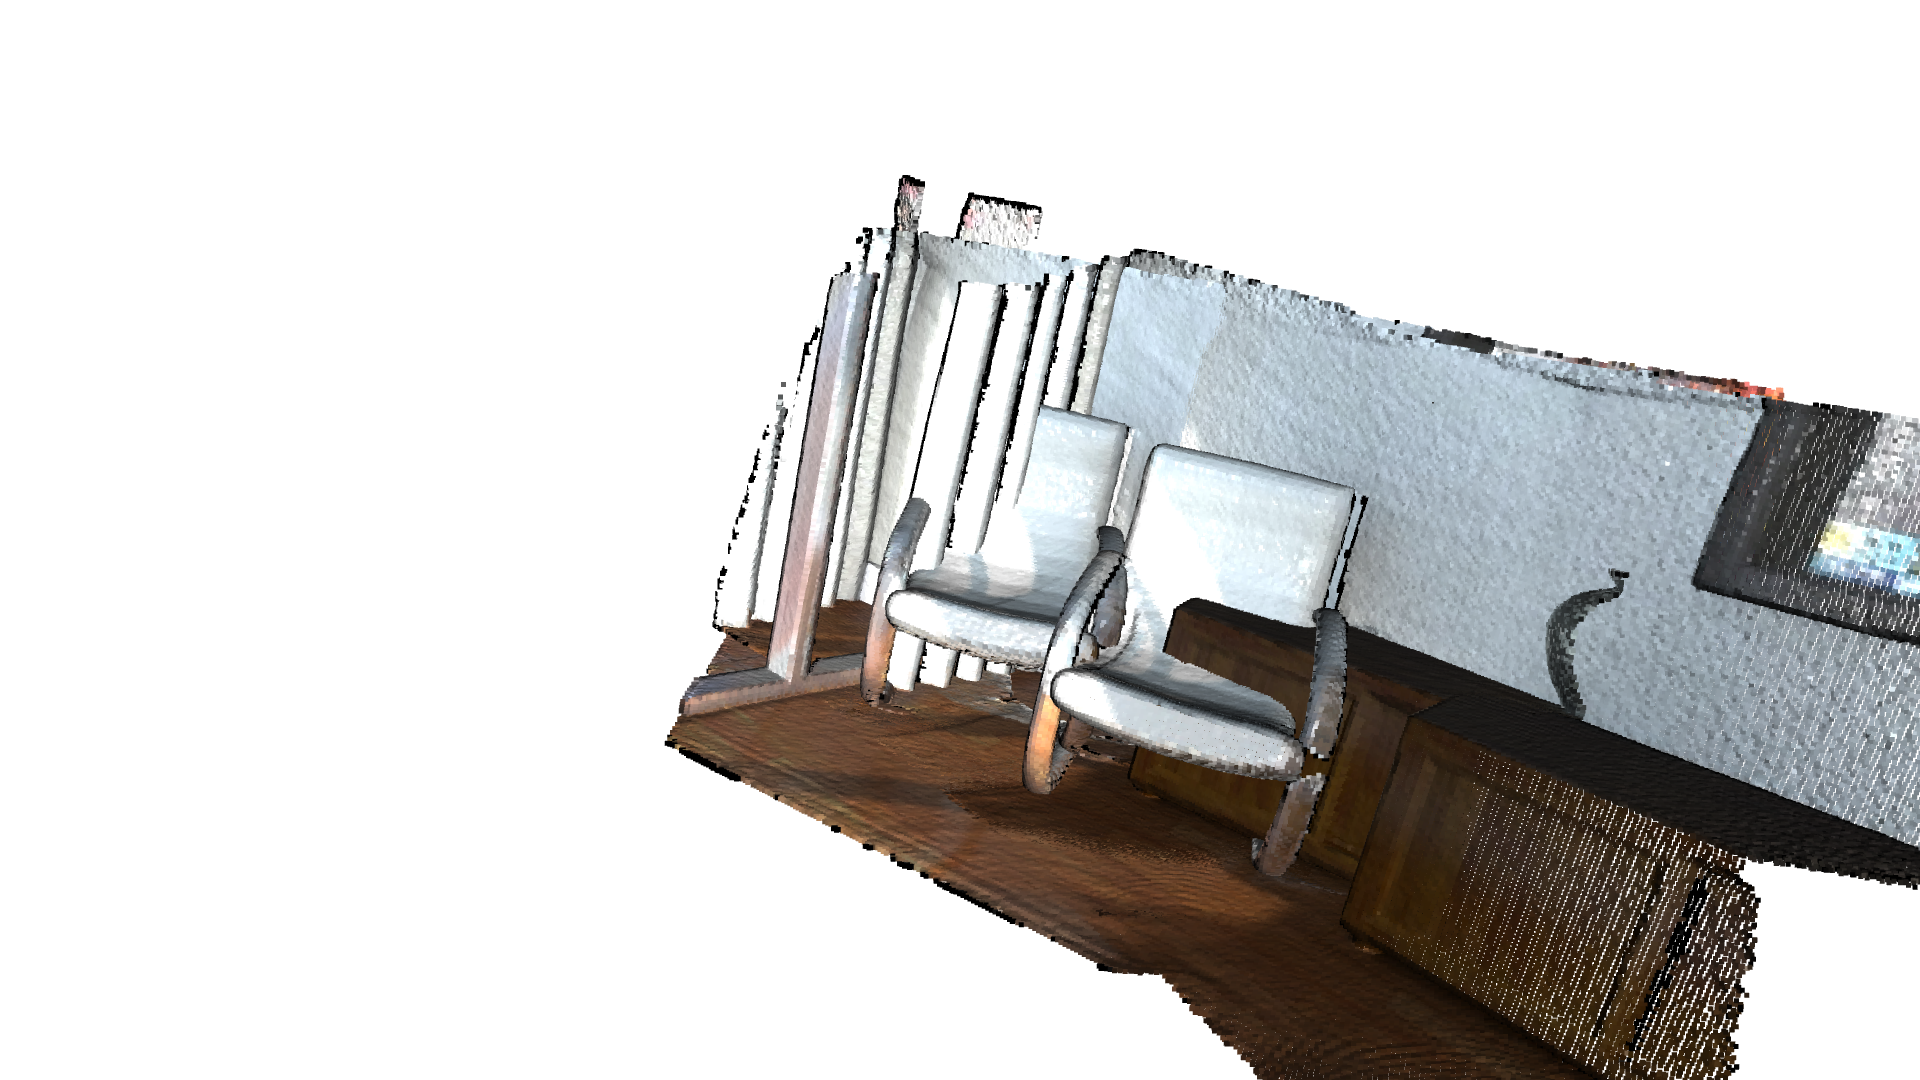

In [14]:
init_source_to_target = o3d.core.Tensor.eye(4, o3d.core.Dtype.Float32)
max_correspondence_distance = 0.07

s = time.time()

registration_result_vanilla_icp = treg.icp(source, target,
                                           max_correspondence_distance,
                                           init_source_to_target, estimation,
                                           criteria, voxel_size, save_info_map)

icp_time = time.time() - s
print("Time taken by ICP: ", icp_time)
print("Inlier Fitness: ", registration_result_vanilla_icp.fitness)
print("Inlier RMSE: ", registration_result_vanilla_icp.inlier_rmse)

draw_registration_result(source, target,
                         registration_result_vanilla_icp.transformation)

### As we can see, poor initial allignment might fail ICP convergence

### Having large `max_correspondence_distance` might resolve this issue. But it will take longer to process.

In [ ]:
init_source_to_target = o3d.core.Tensor.eye(4, o3d.core.Dtype.Float32)
max_correspondence_distance = 0.5

s = time.time()
# It is highly recommended to down-sample the point-cloud before using
# ICP algorithm, for better performance.

registration_result_vanilla_icp = treg.icp(source, target,
                                           max_correspondence_distance,
                                           init_source_to_target, estimation,
                                           criteria, voxel_size, save_info_map)

icp_time = time.time() - s
print("Time taken by ICP: ", icp_time)
print("Inlier Fitness: ", registration_result_vanilla_icp.fitness)
print("Inlier RMSE: ", registration_result_vanilla_icp.inlier_rmse)

draw_registration_result(source, target,
                         registration_result_vanilla_icp.transformation)

### We may resolve the above issues and get even better accuracy by using `Multi-Scale ICP`

---

## Multi-Scale ICP Example

Problems with using Vanilla-ICP (previous version):
- Running the ICP algorithm on dense point-clouds is very slow. 
- It requires good initial alignment:
    - If the point-cloud is not well aligned, the convergence might get stuck in local-minima in initial iterations.
    - We need to have a larger `max_correspondence_distance` if the aligned point cloud does not have sufficient overlaps.  
- If point-cloud is heavily down-sampled (coarse), the obtained result will not be accurate. 

These drawbacks can be solved using Multi-Scale ICP.
In Multi-Scale ICP, we perform the initial iterations on coarse point-cloud to get a better estimate of initial alignment and use this alignment for convergence on a more dense point cloud. ICP on coarse point cloud is in-expensive, and allows us to use a larger `max_correspondence_distance`. It is also less likely for the convergence to get stuck in local minima. As we get a good estimate, it takes fewer iterations on dense point-cloud to converge to a more accurate transform. 

It is recommended to use `Multi-Scale ICP` over `ICP`, for efficient convergence, especially for large point clouds. 

In [ ]:
# Setting Verbosity to Debug, helps in fine-tuning the performance.
# o3d.utility.set_verbosity_level(o3d.utility.VerbosityLevel.Debug)

init_source_to_target = o3d.core.Tensor.eye(4, o3d.core.Dtype.Float32)

s = time.time()

registration_result_multiscale_icp = treg.multi_scale_icp(
    source, target, voxel_sizes, criteria_list, max_correspondence_distances,
    init_source_to_target, estimation, save_info_map)

ms_icp_time = time.time() - s
print("Time taken by Multi-Scale ICP: ", ms_icp_time)
print("Inlier Fitness: ", registration_result_multiscale_icp.fitness)
print("Inlier RMSE: ", registration_result_multiscale_icp.inlier_rmse)

draw_registration_result(source, target,
                         registration_result_multiscale_icp.transformation)

### We can use the `registration_result.info_map`, to plot convergence and fine-tune our application.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt


def plot_rmse(registration_result):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
    axes.set_title("Inlier RMSE vs Iteration")
    axes.plot(registration_result.info_map["index"].numpy(),
              registration_result.info_map["inlier_rmse"].numpy())


def plot_scale_wise_rmse(registration_result):
    scales = registration_result.info_map["scale"].numpy()
    iterations = registration_result.info_map["iteration"].numpy()

    num_scales = scales[-1][0] + 1

    fig, axes = plt.subplots(nrows=1, ncols=num_scales, figsize=(20, 5))

    masks = {}
    for scale in range(0, num_scales):
        masks[scale] = registration_result.info_map["scale"] == scale

        rmse = registration_result.info_map["inlier_rmse"][masks[scale]].numpy()
        iteration = registration_result.info_map["iteration"][
            masks[scale]].numpy()

        title_prefix = "Scale Index: " + str(scale)
        axes[scale].set_title(title_prefix + " Inlier RMSE vs Iteration")
        axes[scale].plot(iteration, rmse)

In [ ]:
print("Vanilla ICP")
plot_rmse(registration_result_vanilla_icp)

In [ ]:
print("Multi Scale ICP")
plot_rmse(registration_result_multiscale_icp)
plot_scale_wise_rmse(registration_result_multiscale_icp)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))

axes.set_title(
    "Vanilla ICP (Yellow) and Multi-Scale ICP (Blue) Inlier RMSE vs Iteration")

if len(registration_result_multiscale_icp.info_map["index"]) > len(
        registration_result_vanilla_icp.info_map["inlier_rmse"]):
    axes.plot(
        registration_result_multiscale_icp.info_map["index"].numpy(),
        registration_result_multiscale_icp.info_map["inlier_rmse"].numpy(),
        registration_result_vanilla_icp.info_map["inlier_rmse"].numpy())
else:
    axes.plot(
        registration_result_vanilla_icp.info_map["index"].numpy(),
        registration_result_vanilla_icp.info_map["inlier_rmse"].numpy(),
        registration_result_multiscale_icp.info_map["inlier_rmse"].numpy())

CPP API for `MultiScaleICP`
```cpp 
RegistrationResult MultiScaleICP(
        const geometry::PointCloud &source,
        const geometry::PointCloud &target,
        const std::vector<double> &voxel_sizes,
        const std::vector<ICPConvergenceCriteria> &criteria_list,
        const std::vector<double> &max_correspondence_distances,
        const core::Tensor &init_source_to_target =
                core::Tensor::Eye(4, core::Float64, core::Device("CPU:0")),
        const TransformationEstimation &estimation =
                TransformationEstimationPointToPoint(),
        const bool save_info_map = false);
```

---

## Multi-Scale ICP on CUDA device Example

In [ ]:
# The algorithm runs on the same device as the source and target point-cloud.
source = source.cuda(0)
target = target.cuda(0)

s = time.time()

registration_result = treg.multi_scale_icp(source, target, voxel_sizes,
                                           criteria_list,
                                           max_correspondence_distances,
                                           init_source_to_target, estimation)

ms_icp_time = time.time() - s
print("Time taken by Multi-Scale ICP: ", ms_icp_time)
print("Inlier Fitness: ", registration_result.fitness)
print("Inlier RMSE: ", registration_result.inlier_rmse)

draw_registration_result(source.cpu(), target.cpu(),
                         registration_result.transformation)

---

### Information Matrix

`Information Matrix` gives us futher information about how well the point-clouds are alligned. 

In [ ]:
information_matrix = treg.get_information_matrix(
    source, target, max_correspondence_distances[2],
    registration_result.transformation)

print(information_matrix)

---

## Summary

---

## Now that we have a basic understanding of the ICP algorithm and the API, let's experiment with the different versions to understand the difference

### Initial Allignment

In [ ]:
source = o3d.t.io.read_point_cloud("../../test_data/ICP/cloud_bin_0.pcd")
target = o3d.t.io.read_point_cloud("../../test_data/ICP/cloud_bin_1.pcd")

# For Colored-ICP `colors` attribute must be of the same dtype as `positions` and `normals` attribute.
source.point["colors"] = source.point["colors"].to(
    o3d.core.Dtype.Float32) / 255.0
target.point["colors"] = target.point["colors"].to(
    o3d.core.Dtype.Float32) / 255.0

# Initial guess transform between the two point-cloud.
# ICP algortihm requires a good initial allignment to converge efficiently.
trans_init = np.asarray([[0.862, 0.011, -0.507, 0.5],
                         [-0.139, 0.967, -0.215, 0.7],
                         [0.487, 0.255, 0.835, -1.4], [0.0, 0.0, 0.0, 1.0]])

draw_registration_result(source, target, trans_init)

In [ ]:
# Search distance for Nearest Neighbour Search [Hybrid-Search is used].
max_correspondence_distance = 0.02

print("Initial alignment")
evaluation = o3d.t.pipelines.registration.evaluate_registration(
    source, target, max_correspondence_distance, trans_init)

print("Fitness: ", evaluation.fitness)
print("Inlier RMSE: ", evaluation.inlier_rmse)

---
## Point-To-Point ICP Registration 

We first show a point-to-point ICP algorithm [\[BeslAndMcKay1992\]](../reference.html#beslandmckay1992) using the objective

\begin{equation}
E(\mathbf{T}) = \sum_{(\mathbf{p},\mathbf{q})\in\mathcal{K}}\|\mathbf{p} - \mathbf{T}\mathbf{q}\|^{2}
\end{equation}

The class `TransformationEstimationPointToPoint` provides functions to compute the residuals and Jacobian matrices of the point-to-point ICP objective.

In [ ]:
print("Apply Point-to-Point ICP")
s = time.time()

max_correspondence_distance = 0.02
init_source_to_target = trans_init
estimation = treg.TransformationEstimationPointToPoint()
criteria = treg.ICPConvergenceCriteria(relative_fitness=0.0000001,
                                       relative_rmse=0.0000001,
                                       max_iteration=30)
voxel_size = -1
save_info_map = True

reg_point_to_point = treg.icp(source, target, max_correspondence_distance,
                              init_source_to_target, estimation, criteria,
                              voxel_size, save_info_map)

icp_time = time.time() - s

print("Time taken by Point-To-Point ICP: ", icp_time)
print("Fitness: ", reg_point_to_point.fitness)
print("Inlier RMSE: ", reg_point_to_point.inlier_rmse)

draw_registration_result(source, target, reg_point_to_point.transformation)

The fitness score increases from `0.174722` to `0.372474`. The inlier_rmse reduces from `0.011771` to `0.007761`. 
By default, icp runs until convergence or reaches a maximum number of iterations (30 by default). 
It can be changed to allow more computation time and to improve the results further.

In [ ]:
print("Apply Point-to-Point ICP")
s = time.time()

criteria = treg.ICPConvergenceCriteria(relative_fitness=0.0000001,
                                       relative_rmse=0.0000001,
                                       max_iteration=1000)

reg_point_to_point = treg.icp(source, target, max_correspondence_distance,
                              init_source_to_target, estimation, criteria,
                              voxel_size, save_info_map)

icp_time = time.time() - s

print("Time taken by Point-To-Point ICP: ", icp_time)
print("Fitness: ", reg_point_to_point.fitness)
print("Inlier RMSE: ", reg_point_to_point.inlier_rmse)

draw_registration_result(source, target, reg_point_to_point.transformation)

The final alignment is tight. The fitness score improves to `0.620972`. The inlier_rmse reduces to `0.006581`.

---

## Point-to-Plane ICP Registration
The point-to-plane ICP algorithm [\[ChenAndMedioni1992\]](../reference.html#chenandmedioni1992) uses a different objective function

\begin{equation}
E(\mathbf{T}) = \sum_{(\mathbf{p},\mathbf{q})\in\mathcal{K}}\big((\mathbf{p} - \mathbf{T}\mathbf{q})\cdot\mathbf{n}_{\mathbf{p}}\big)^{2},
\end{equation}

where $\mathbf{n}_{\mathbf{p}}$ is the normal of point $\mathbf{p}$. [\[Rusinkiewicz2001\]](../reference.html#rusinkiewicz2001) has shown that the point-to-plane ICP algorithm has a faster convergence speed than the point-to-point ICP algorithm.

The class `TransformationEstimationPointToPlane` provides functions to compute the residuals and Jacobian matrices of the point-to-plane ICP objective. 

In [ ]:
print("Apply Point-to-Plane ICP")
s = time.time()

max_correspondence_distance = 0.02
init_source_to_target = trans_init
estimation = treg.TransformationEstimationPointToPlane()
criteria = treg.ICPConvergenceCriteria(relative_fitness=0.0000001,
                                       relative_rmse=0.0000001,
                                       max_iteration=30)
voxel_size = -1
save_info_map = True

reg_point_to_plane = treg.icp(source, target, max_correspondence_distance,
                              init_source_to_target, estimation, criteria,
                              voxel_size, save_info_map)

icp_time = time.time() - s

print("Time taken by Point-To-Plane ICP: ", icp_time)
print("Fitness: ", reg_point_to_plane.fitness)
print("Inlier RMSE: ", reg_point_to_plane.inlier_rmse)

draw_registration_result(source, target, reg_point_to_plane.transformation)

The point-to-plane ICP reaches tight alignment within 30 iterations (a `fitness` score of 0.620972 and an `inlier_rmse` score of 0.006581).

---
# Robust Kernel

This tutorial demonstrates the use of robust kernels in the context of outlier rejection. For this particular tutorial, we will be using the ICP (Iterative Closest Point) registration algorithm as the _target_ problem where we want to deal with outliers. Even so, the theory applies to any given optimization problem and not just for ICP. For the moment the robust kernels have been only implemented for the `PointToPlane` ICP.

The notation and some of the kernels implemented in `Open3D` has been inspired by the publication "Analysis of Robust Functions for Registration Algorithms" [\[Babin2019\]](../reference.html#babin2019)

## Point-to-plane ICP using Robust Kernels

The standard point-to-plane ICP algorithm [\[ChenAndMedioni1992\]](../reference.html#chenandmedioni1992) minimizes this objective function:

\begin{equation}
E(\mathbf{T}) = \sum_{(\mathbf{p},\mathbf{q})\in\mathcal{K}}\big((\mathbf{p} - \mathbf{T}\mathbf{q})\cdot\mathbf{n}_{\mathbf{p}}\big)^{2},
\end{equation}

where $\mathbf{n}_{\mathbf{p}}$ is the normal of point $\mathbf{p}$ and $\mathcal{K}$ is the correspondence set between the target point cloud $\mathbf{P}$, and source point cloud $\mathbf{Q}$.

If we call $r_i(\mathbf{T})$ is $i^\mathrm{th}$ the residual, for a given pair of correspondences $(\mathbf{p},\mathbf{q})\in\mathcal{K}$ we can rewrite the objective function as.

\begin{equation}
E(\mathbf{T}) = \sum_{(\mathbf{p},\mathbf{q})\in\mathcal{K}}\big((\mathbf{p} - \mathbf{T}\mathbf{q})\cdot\mathbf{n}_{\mathbf{p}}\big)^{2} = \sum_{i=1}^{N} \big({r_i(\mathbf{T})}\big)^2
\end{equation}

The optimization problem above can also be solved by using the iteratively reweighted least-squares (IRLS) approach, which solves a sequence of weighted least squares problems:

\begin{equation}
E(\mathbf{T}) =  \sum_{i=1}^{N} w_i \big({r_i(\mathbf{T})}\big)^2
\end{equation}

### Outlier Rejection with Robust Kernels

The main idea of a robust loss is to downweight large residuals that are assumed to be caused from outliers such that their influence on the solution is reduced. This is achieved by optimizing $E(\mathbf{T})$ as:

\begin{equation}
E(\mathbf{T}) = \sum_{(\mathbf{p},\mathbf{q})\in\mathcal{K}}\rho\big((\mathbf{p} - \mathbf{T}\mathbf{q})\cdot\mathbf{n}_{\mathbf{p}}\big) = \sum_{i=1}^{N} \rho\big({r_i(\mathbf{T})}\big),
\end{equation}

where $\rho(r)$ is also called the robust loss or kernel.

We can see that exists a relation between the optimization formulation in IRLS and the one that uses the robust loss function. By setting the weight $w_i= \frac{1}{r_i(\mathbf{T})}\rho'(r_i(\mathbf{T}))$, we can solve the robust loss optimization problem using the existing techniques for weighted least-squares. Therefore, we can minimize the objective function using Gauss-Newton and determine increments by iteratively solving:

\begin{align}
\left(\mathbf{J}^\top \mathbf{W} \mathbf{J}\right)^{-1}\mathbf{J}^\top\mathbf{W}\vec{r},
\end{align}

where $\mathbf{W} \in \mathbb{R}^{N\times N}$ is a diagonal matrix containing weights $w_i$ for each residual $r_i$

### How to use Robust Kernels in Open3D

`registration_icp` can be called with a parameter `TransformationEstimationPointToPlane(loss)`. Where `loss` is a given loss function(also called robust kernel). 

Internally, `TransormationEstimationPointToPlane(loss)` implements a function to compute the weighted residuals and Jacobian matrices of the point-to-plane ICP objective according to the provided robust kernel.

## Vanilla ICP vs Robust ICP

To better show the advantages of using robust kernels in the registration, we add some artificially generated gaussian noise to the source point cloud.

In [ ]:
def apply_noise(pcd, mu, sigma):
    device = pcd.point["positions"].device
    noisy_pcd = pcd.cpu().clone()
    noisy_pcd.point["positions"] += o3d.core.Tensor(
        np.random.normal(mu, sigma, size=noisy_pcd.point["positions"].shape),
        noisy_pcd.point["positions"].dtype)
    return noisy_pcd


mu, sigma = 0, 0.1  # mean and standard deviation
source_noisy = apply_noise(source, mu, sigma)

print("Source PointCloud + noise:")
o3d.visualization.draw([source_noisy])

### Vanilla ICP

We inspect how the results will look if we use the exact same parameters that were used in the above examples of ICP.

In [ ]:
max_correspondence_distance = 0.02

init_source_to_target = trans_init
estimation = treg.TransformationEstimationPointToPlane()

print("Vanilla point-to-plane ICP, max_correspondence_distance={}:".format(
    max_correspondence_distance))
s = time.time()

reg_point_to_plane = treg.icp(source_noisy, target, max_correspondence_distance,
                              init_source_to_target, estimation)

icp_time = time.time() - s

print("Time taken by Point-To-Plane ICP: ", icp_time)
print("Fitness: ", reg_point_to_plane.fitness)
print("Inlier RMSE: ", reg_point_to_plane.inlier_rmse)

draw_registration_result(source, target, reg_point_to_plane.transformation)

### Tuning Vanilla ICP

Given the fact that we are now dealing with gaussian noise, we might try to increase the threshold to search for nearest neighbors with the aim of improving the registration result.

We can see that under these condtions and without a robust kernel, the traditional ICP has no chance to deal with  outliers.

In [ ]:
max_correspondence_distance = 1.0

estimation = treg.TransformationEstimationPointToPlane()
init_source_to_target = trans_init

print("Vanilla point-to-plane ICP, max_correspondence_distance={}:".format(
    max_correspondence_distance))

s = time.time()

reg_point_to_plane = treg.icp(source_noisy, target, max_correspondence_distance,
                              init_source_to_target, estimation)

icp_time = time.time() - s

print("Time taken by Point-To-Plane ICP: ", icp_time)
print("Fitness: ", reg_point_to_plane.fitness)
print("Inlier RMSE: ", reg_point_to_plane.inlier_rmse)

draw_registration_result(source, target, reg_point_to_plane.transformation)

### Robust ICP

Using the same `threshold=1.0` **and** a robust kernel, we can properly register the two point clouds:

In [ ]:
max_correspondence_distance = 1.0

mu, sigma = 0, 0.1  # mean and standard deviation
estimation = treg.TransformationEstimationPointToPlane(
    treg.robust_kernel.RobustKernel(
        treg.robust_kernel.RobustKernelMethod.TukeyLoss, sigma))

init_source_to_target = trans_init

print("Vanilla point-to-plane ICP, max_correspondence_distance={}:".format(
    max_correspondence_distance))

s = time.time()

reg_point_to_plane = treg.icp(source_noisy, target, max_correspondence_distance,
                              init_source_to_target, estimation)

icp_time = time.time() - s

print("Time taken by Point-To-Plane ICP: ", icp_time)
print("Fitness: ", reg_point_to_plane.fitness)
print("Inlier RMSE: ", reg_point_to_plane.inlier_rmse)

draw_registration_result(source, target, reg_point_to_plane.transformation)

#### Estimation Method supports `Robust Kernels`: Robust kernels are used for outlier rejection. More on this in `Robust Kernel` section.

`robust_kernel = o3d.t.pipelines.registration.robust_kernel.RobustKernel(method, scale, shape)`
Method options
- robust_kernel.RobustKernelMethod.L2Loss
- robust_kernel.RobustKernelMethod.L1Loss
- robust_kernel.RobustKernelMethod.HuberLoss
- robust_kernel.RobustKernelMethod.CauchyLoss
- robust_kernel.RobustKernelMethod.GMLoss
- robust_kernel.RobustKernelMethod.TukeyLoss
- robust_kernel.RobustKernelMethod.GeneralizedLoss

<div class="alert alert-info">
    
**Note:** 

For this example we use the **TukeyLoss**. For the parameter `k` we set it to match the std deviation of the noise model $k = \sigma$.
The parameter `k` used in the Robust Kernels it's usually pick to match the standard deviation of the noise model of the input data. In this sense, `k`, is the discriminator between **inlier**/**outlier**. Altough this is not always trivial to define in real world data, for synthetic one, it's easy to fix in order to illustrate the benefits of the robust kernels.
 
</div>

---